**15장 – RNN과 CNN을 사용해 시퀀스 처리하기**

_이 노트북에는 15장의 모든 샘플 코드와 연습 문제에 대한 해답이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [33]:
import sys

assert sys.version_info >= (3, 7)

import numpy as np

그리고 TensorFlow ≥ 2.8:

In [34]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# import sys
# # 코랩의 경우 나눔 폰트를 설치합니다.
# if 'google.colab' in sys.modules:
#     !sudo apt-get -qq -y install fonts-nanum
#     import matplotlib.font_manager as fm
#     font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
#     for fpath in font_files:
#         fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
import matplotlib.pyplot as plt


def get_font_family():
    import platform
    system_name = platform.system()
    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    elif system_name == "Linux":
        font_family = "NanumGothic"
    return font_family


font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format='retina'

그리고 `images/rnn` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [38]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    # plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [39]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.")

# 기본 RNN

`ageron/data` 저장소트에서 승객 데이터를 다운로드해 보겠습니다. 원래는 시카고 교통국에서 제공한 것으로, [시카고 데이터 포털](https://homl.info/ridership)에서 다운로드할 수 있습니다.

In [40]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership.tgz'

In [41]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # 더 짧은 이름
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # total은 단순히 bus + rail 이므로 삭제합니다.
df = df.drop_duplicates()  # 중복된 월 제거 (2011-10와 2014-07)

In [42]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


2019년의 첫 몇 달을 살펴봅시다(판다스에서는 범위의 경계를 포함합니다):

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' n

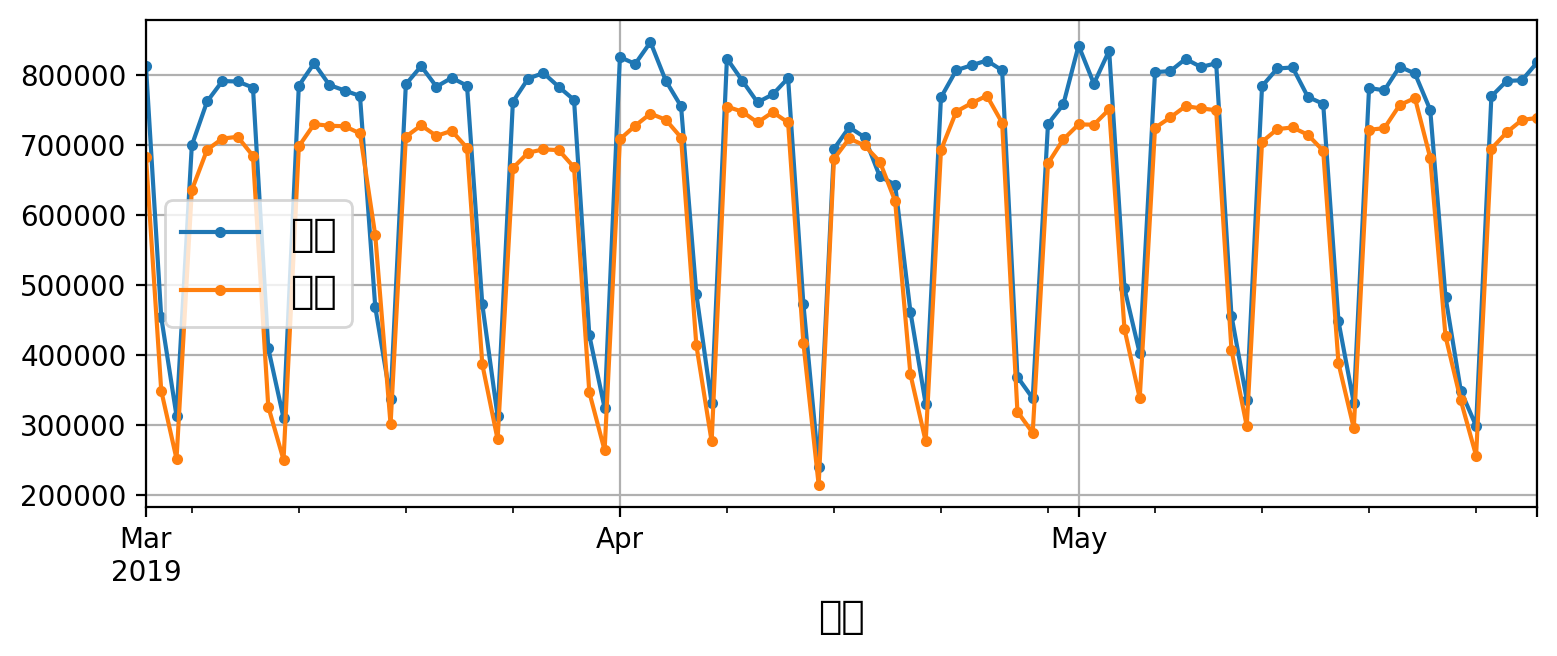

In [43]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.legend(["버스", "열차"]);
plt.xlabel("날짜")
save_fig("daily_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykerne

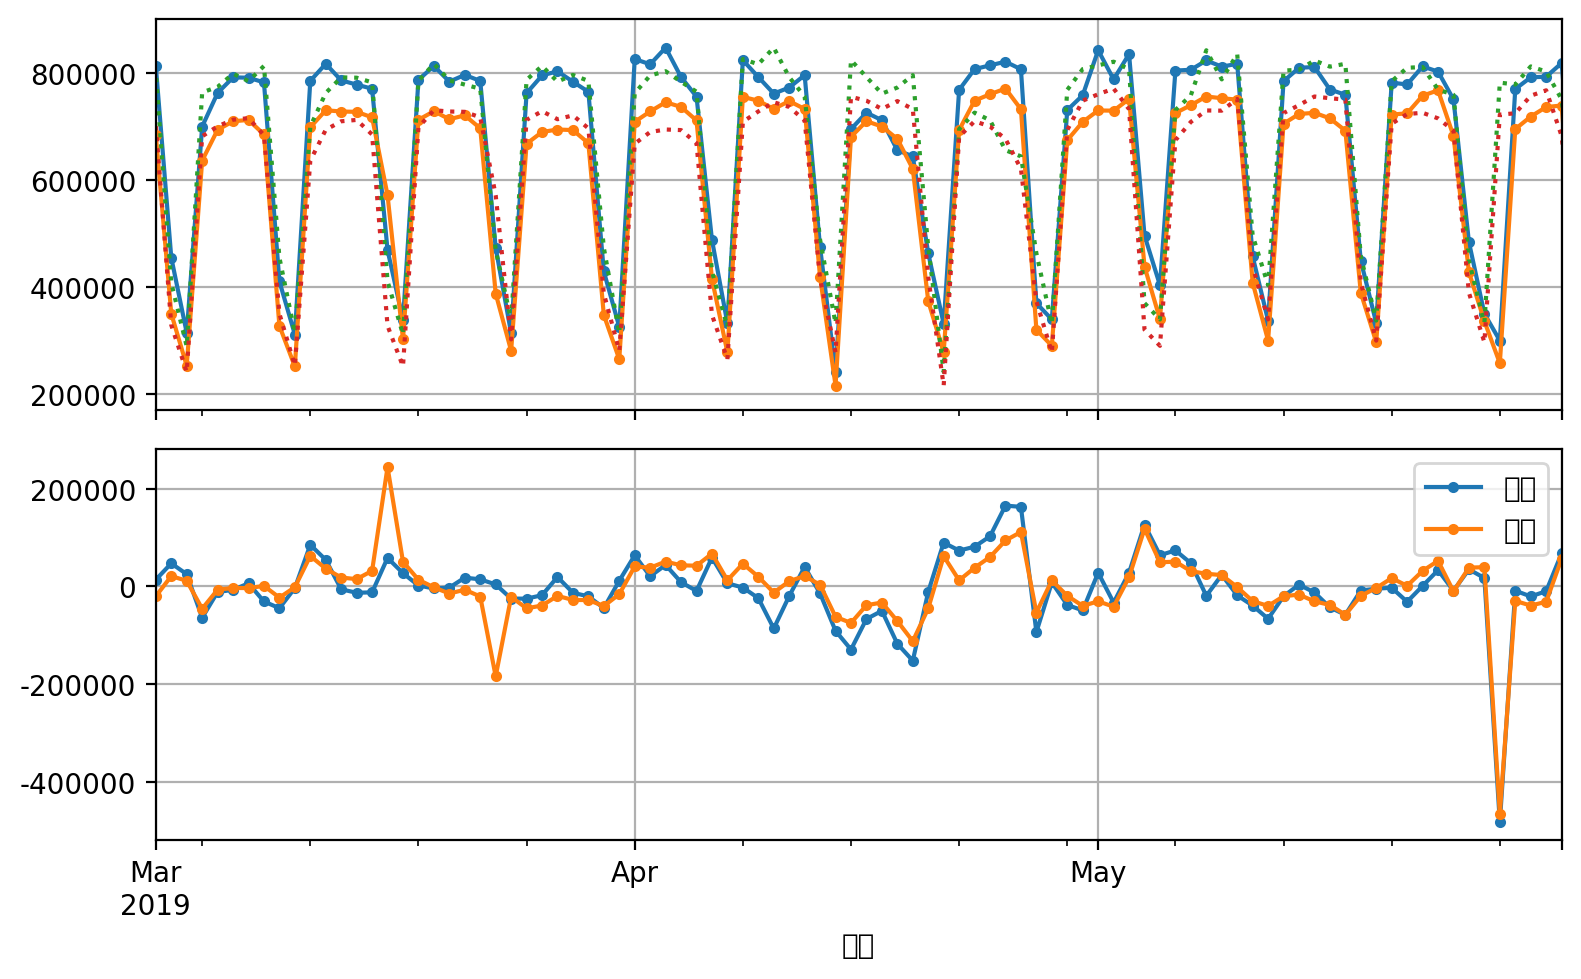

In [15]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # 원본 시계열
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 지연
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7일 차분 시계열
axs[1].legend(["버스", "열차"])
axs[1].set_xlabel("날짜")
axs[0].set_ylim([170_000, 900_000])  # 추가 코드 - 그래프를 아름답게 꾸미기
save_fig("differencing_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

In [25]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

평균 절대 오차(MAE)는 평균 절대 편차(MAD)라고도 합니다:

In [26]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

평균 절대 비율 오류(MAPE):

In [27]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

이제 연도별 계절성과 장기 트렌드를 살펴보겠습니다:

/tmp/ipykernel_24/2125188364.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean(numeric_only=True)  # 월별 평균을 계산합니다.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu San

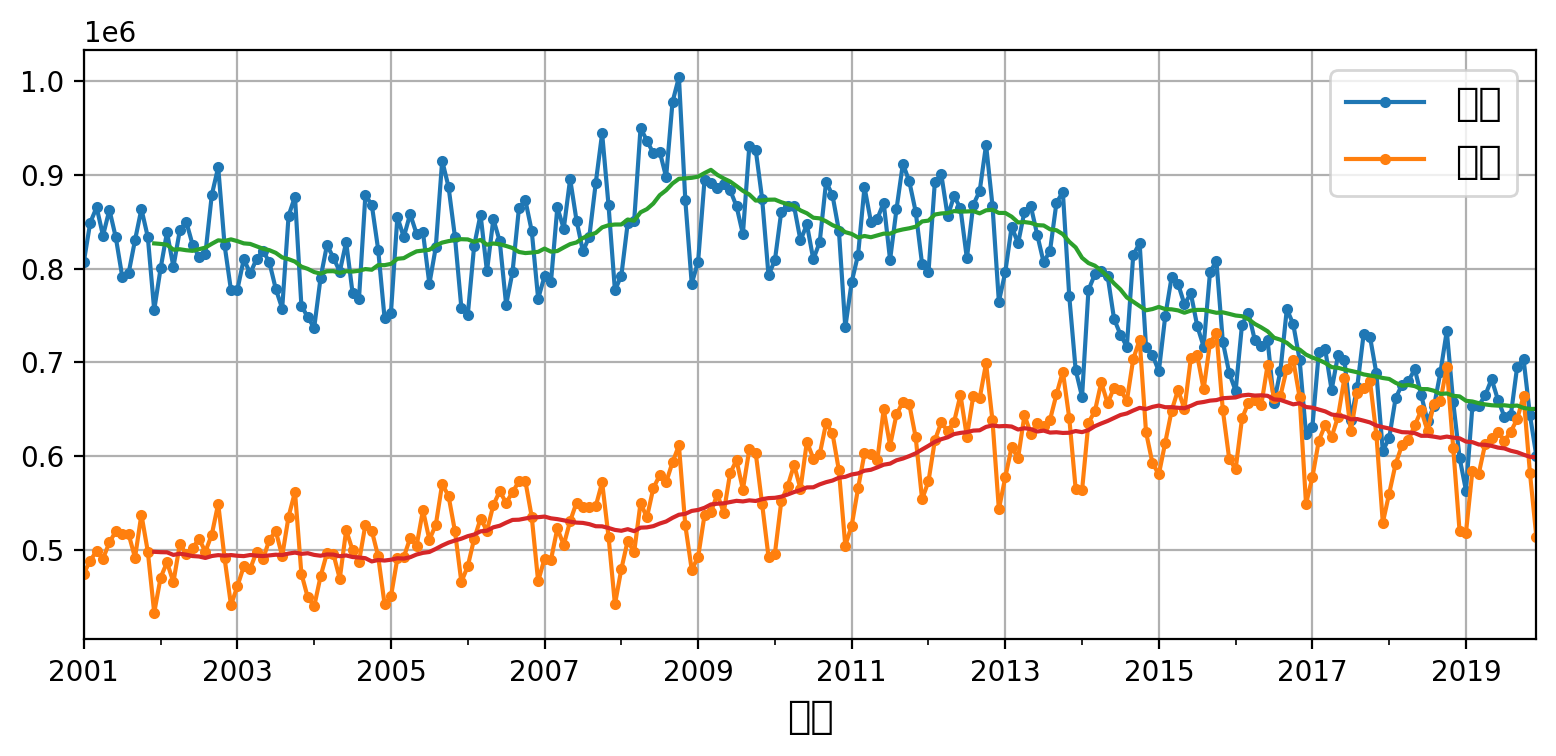

In [44]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # 월별 평균을 계산합니다.
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
ax.legend(["버스", "열차"]);
ax.set_xlabel('날짜')
save_fig("long_term_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_24/4235788305.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumBarunGothic' n

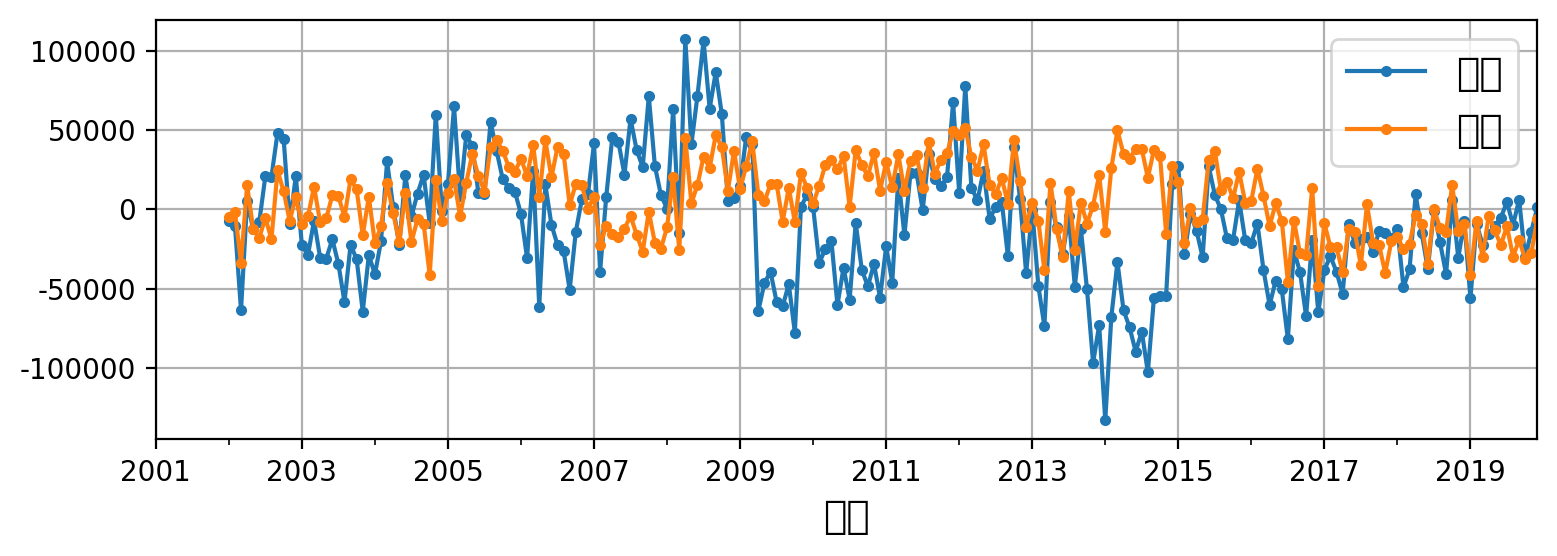

In [45]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.legend(["버스", "열차"])
plt.xlabel("날짜")
save_fig("yearly_diff_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

Colab에서 실행하는 경우 `statsmodels` 라이브러리를 설치합니다:

In [46]:
# if "google.colab" in sys.modules:
#     %pip install -q -U statsmodels

In [47]:
!pip install -q -U statsmodels


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [48]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # 427,758.6 반환

In [49]:
y_pred[0]  # ARIMA 예측

/tmp/ipykernel_24/3717318111.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA 예측


427758.62641035335

In [50]:
df["rail"].loc["2019-06-01"]  # 타깃 값

379044

In [51]:
df["rail"].loc["2019-05-25"]  # 순진한 예측(1주일 전의 값)

426932

In [52]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # "오늘"까지의 데이터로 훈련
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # 매일 모델을 재훈련한다는 점에 유의하세요!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # 32,040.7 반환

/tmp/ipykernel_24/735791386.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_24/735791386.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_24/735791386.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
/tmp/ipykernel_24/735791386.py:10: FutureWarning: Series.__getitem__ treating keys as positions is depreca

In [53]:
mae

32040.720089453378

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBa

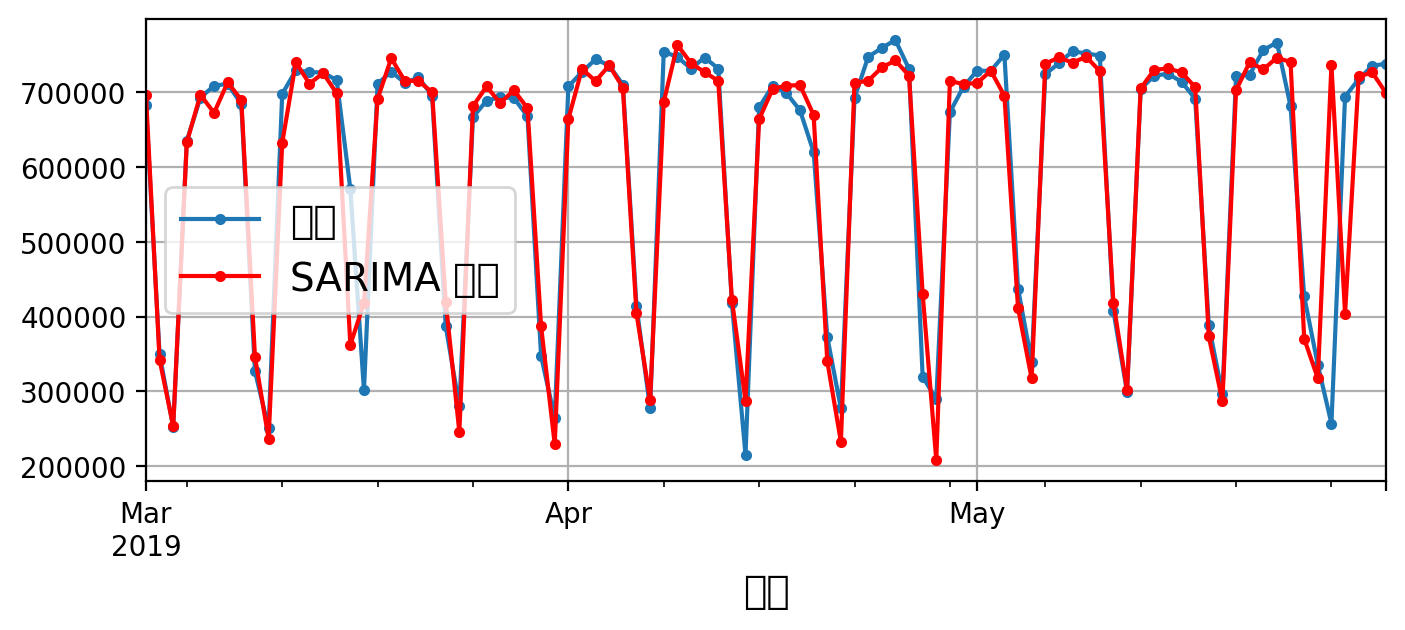

In [54]:
# 추가 코드 - SARIMA 예측을 표시합니다.
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="실제", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA 예측")
ax.set_xlabel("날짜")
plt.legend()
plt.show()

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

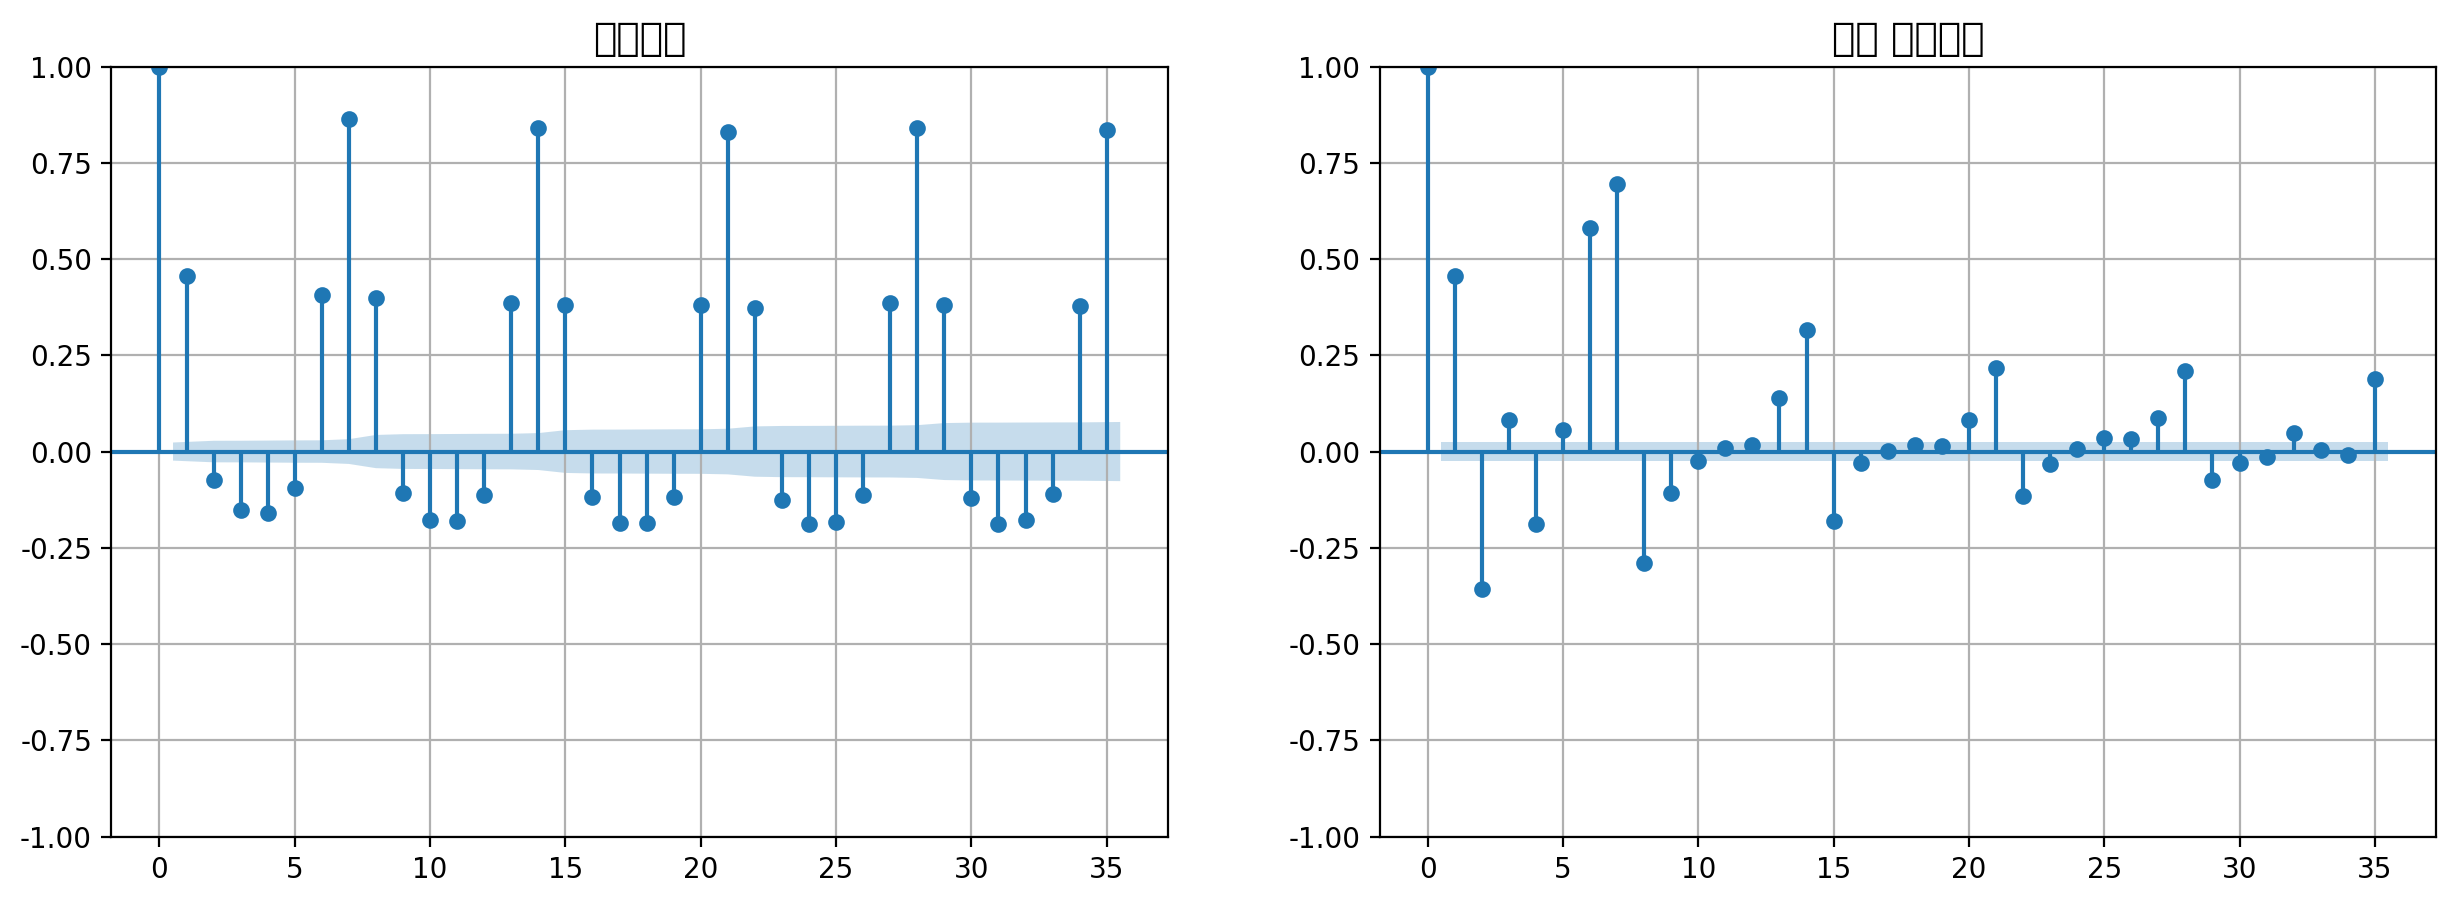

In [55]:
# 추가 코드 - 자기 상관관계 함수(ACF) 및
# 부분 자기 상관관계 함수(PACF)를 그리는 방법을 보여줍니다.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35, title="자기상관")
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm",
          title="부분 자기상관")
axs[1].grid()
plt.show()

In [56]:
# TensorFlow 라이브러리를 가져옵니다.
import tensorflow as tf

# 간단한 시계열 데이터를 생성합니다.
my_series = [0, 1, 2, 3, 4, 5]

# 시계열 데이터셋을 생성합니다.
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,  # 입력 시계열 데이터
    targets=my_series[3:],  # 타깃은 입력보다 3 스텝 앞선 값입니다.
    sequence_length=3,  # 각 시퀀스의 길이를 3으로 설정합니다.
    batch_size=2  # 배치 크기를 2로 설정합니다.
)

# 생성된 데이터셋을 리스트로 변환하여 출력합니다.
# 이를 통해 데이터셋의 구조를 확인할 수 있습니다.
list(my_dataset)

I0000 00:00:1728814564.577081      24 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728814564.577167      24 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728814564.577192      24 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728814564.774094      24 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728814564.774148      24 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [57]:
my_series = [0, 1, 2, 3, 4, 5]

for window_dataset in tf.data.Dataset.from_tensor_slices(my_series).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-10-13 10:16:05.366319: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-13 10:16:05.370228: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-13 10:16:05.377622: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-13 10:16:05.387976: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [59]:
# 0부터 5까지의 숫자로 데이터셋을 생성합니다.
dataset = tf.data.Dataset.range(6)

# 윈도우 크기 4, 이동 간격 1로 윈도우를 생성합니다. 
# drop_remainder=True는 마지막에 크기가 4 미만인 윈도우를 버립니다.
dataset = dataset.window(4, shift=1, drop_remainder=True)

# 각 윈도우를 하나의 텐서로 변환합니다.
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))

# 각 윈도우 텐서를 출력합니다.
for window_tensor in dataset:
    print(f"{window_tensor}")

# 결과로 [0 1 2 3], [1 2 3 4], [2 3 4 5] 세 개의 윈도우가 생성됩니다.

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2024-10-13 10:16:06.041662: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [60]:
def to_windows(dataset, length):
    # 데이터셋을 주어진 길이의 윈도우로 변환합니다.
    # length: 각 윈도우의 길이
    # shift=1: 각 윈도우는 1씩 이동하며 생성됩니다.
    # drop_remainder=True: 마지막에 length보다 작은 윈도우는 버립니다.
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    
    # 각 윈도우를 하나의 텐서로 변환합니다.
    # flat_map을 사용하여 윈도우 데이터셋을 펼치고, 각 윈도우를 배치로 만듭니다.
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [61]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

데이터를 계속 살펴보기 전에 훈련, 검증 및 테스트를 위해 시계열을 세 가지 기간으로 나누어 보겠습니다. 지금은 테스트 데이터를 살펴보지 않겠습니다:

In [62]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [63]:
# 시퀀스의 길이를 56으로 설정합니다. 이는 8주(56일) 동안의 데이터를 사용하여 다음 날을 예측하겠다는 의미입니다.
seq_length = 56

# 난수 생성을 위한 시드를 설정하여 결과의 재현성을 보장합니다.
tf.random.set_seed(42)

# 훈련 데이터셋을 생성합니다.
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),  # 입력 데이터: 2016년부터 2018년까지의 철도 이용객 수
    targets=rail_train[seq_length:],  # 타겟 데이터: 입력 데이터에서 seq_length만큼 이동한 값들
    sequence_length=seq_length,  # 각 시퀀스의 길이
    batch_size=32,  # 배치 크기
    shuffle=True,  # 데이터를 섞어서 과적합을 방지
    seed=42  # 셔플링을 위한 시드 설정
)

# 검증 데이터셋을 생성합니다.
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),  # 입력 데이터: 2019년 1월부터 5월까지의 철도 이용객 수
    targets=rail_valid[seq_length:],  # 타겟 데이터: 입력 데이터에서 seq_length만큼 이동한 값들
    sequence_length=seq_length,  # 각 시퀀스의 길이
    batch_size=32  # 배치 크기 (검증 데이터는 셔플링하지 않습니다)
)

### 선형 모델로 예측하기

In [64]:
# 재현성을 위해 랜덤 시드를 설정합니다.
tf.random.set_seed(42)

# 선형 모델을 정의합니다.
model = tf.keras.Sequential([
    # 입력 시퀀스 길이(seq_length)를 받아 하나의 출력을 내는 Dense 층을 추가합니다.
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

# 조기 종료 콜백을 정의합니다.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",  # 검증 세트의 평균 절대 오차를 모니터링합니다.
    patience=50,  # 50 에포크 동안 개선이 없으면 훈련을 중단합니다.
    restore_best_weights=True  # 최상의 모델 가중치를 복원합니다.
)

# 확률적 경사 하강법(SGD) 옵티마이저를 정의합니다.
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

# 모델을 컴파일합니다.
model.compile(
    loss=tf.keras.losses.Huber(),  # Huber 손실 함수를 사용합니다.
    optimizer=opt,
    metrics=["mae"]  # 평균 절대 오차를 메트릭으로 사용합니다.
)

# 모델을 훈련시킵니다.
history = model.fit(
    train_ds,  # 훈련 데이터셋
    validation_data=valid_ds,  # 검증 데이터셋
    epochs=500,  # 최대 500 에포크 동안 훈련합니다.
    callbacks=[early_stopping_cb]  # 조기 종료 콜백을 사용합니다.
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1728814570.413896     255 service.cc:146] XLA service 0x7f54d4006100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728814570.413940     255 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-13 10:16:10.427453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 10:16:10.467641: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0418 - mae: 0.2312   

I0000 00:00:1728814570.654459     255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0413 - mae: 0.2293 - val_loss: 0.0061 - val_mae: 0.0832
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.1050 - val_loss: 0.0050 - val_mae: 0.0743
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mae: 0.0960 - val_loss: 0.0050 - val_mae: 0.0735
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0884 - val_loss: 0.0044 - val_mae: 0.0692
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - mae: 0.0787 - val_loss: 0.0042 - val_mae: 0.0677
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0770 - val_loss: 0.0041 - val_mae: 0.0659
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - mae: 0.0725 - val_loss: 0.0039 - val_mae: 0.0647
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0776 - val_loss: 0.0039 - val_mae: 0.0623
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mae: 0.

In [65]:
# 추가 코드 - 모델을 평가합니다.
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mae: 0.0392 


37690.721452236176

## 간단한 RNN 사용

In [66]:
# 재현성을 위해 랜덤 시드를 설정합니다.
tf.random.set_seed(42)

# 간단한 RNN 모델을 정의합니다.
model = tf.keras.Sequential([
    # SimpleRNN 층을 추가합니다.
    # - 1개의 유닛(뉴런)을 가집니다.
    # - input_shape=[None, 1]은 가변 길이의 시퀀스와 각 시점마다 1개의 특성을 가진 입력을 의미합니다.
    #   None은 시퀀스 길이가 가변적임을 나타냅니다.
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
# 여러 번 재사용할 유틸리티 함수를 정의합니다.

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    # 조기 종료 콜백을 설정합니다.
    # 검증 세트의 MAE가 50 에포크 동안 개선되지 않으면 훈련을 중단합니다.
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    
    # SGD 옵티마이저를 설정합니다. 모멘텀을 사용하여 학습 속도를 개선합니다.
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # 모델을 컴파일합니다. Huber 손실 함수와 MAE 메트릭을 사용합니다.
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    
    # 모델을 훈련시킵니다.
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    
    # 검증 세트에 대해 모델을 평가합니다.
    valid_loss, valid_mae = model.evaluate(valid_set)
    
    # MAE를 마이크로초 단위로 변환하여 반환합니다.
    return valid_mae * 1e6

In [68]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0421 - mae: 0.2316 - val_loss: 0.0216 - val_mae: 0.1726
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0191 - mae: 0.1567 - val_loss: 0.0198 - val_mae: 0.1543
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0183 - mae: 0.1525 - val_loss: 0.0192 - val_mae: 0.1508
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0172 - mae: 0.1518 - val_loss: 0.0187 - val_mae: 0.1478
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0171 - mae: 0.1541 - val_loss: 0.0183 - val_mae: 0.1456
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0169 - mae: 0.1490 - val_loss: 0.0178 - val_mae: 0.1478
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0171 - mae: 0.1576 - val_loss: 0.0175 - val_mae: 0.1452
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0165 - mae: 0.1570 - val_loss: 0.0178 - val_mae: 0.1387
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

102781.29577636719

In [69]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # 기본적으로 활성화 함수 없음
])

In [70]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0132 - mae: 0.1283 - val_loss: 0.0100 - val_mae: 0.1247
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0069 - mae: 0.0907 - val_loss: 0.0023 - val_mae: 0.0429
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0041 - mae: 0.0593 - val_loss: 0.0021 - val_mae: 0.0387
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - mae: 0.0550 - val_loss: 0.0021 - val_mae: 0.0355
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039 - mae: 0.0531 - val_loss: 0.0020 - val_mae: 0.0374
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0039 - mae: 0.0546 - val_loss: 0.0021 - val_mae: 0.0347
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0029 - mae: 0.0472 - val_loss: 0.0025 - val_mae: 0.0408
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0028 - val_mae: 0.0499
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - lo

30507.391318678856

## 심층 RNN

In [71]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [72]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0828 - mae: 0.3094 - val_loss: 0.0277 - val_mae: 0.1611
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0181 - mae: 0.1546 - val_loss: 0.0131 - val_mae: 0.1117
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0129 - mae: 0.1370 - val_loss: 0.0084 - val_mae: 0.0910
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0088 - mae: 0.1094 - val_loss: 0.0039 - val_mae: 0.0669
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0063 - mae: 0.0836 - val_loss: 0.0025 - val_mae: 0.0489
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0022 - val_mae: 0.0452
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0044 - mae: 0.0637 - val_loss: 0.0022 - val_mae: 0.0436
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0044 - mae: 0.0603 - val_loss: 0.0024 - val_mae: 0.0449
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - lo

KeyboardInterrupt: 

## 다변량 시계열

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # 버스 및 열차 시계열을 모두 입력으로 사용
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # 내일의 유형을 알고 있습니다.
df_mulvar = pd.get_dummies(df_mulvar)  # 요일 유형을 원-핫 인코딩합니다.

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
import numpy as np

# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)

# 다변량 시계열 데이터셋 생성 (훈련용)
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),  # 모든 특성(5개 열)을 입력으로 사용
    targets=mulvar_train["rail"][seq_length:],  # 열차 승객 수만 예측 대상으로 설정
    sequence_length=seq_length,  # 시퀀스 길이 설정
    batch_size=32,  # 배치 크기 설정
    shuffle=True,  # 데이터 섞기 활성화
    seed=42  # 셔플링의 재현성을 위한 시드 설정
)

# 다변량 시계열 데이터셋 생성 (검증용)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),  # 검증 데이터의 모든 특성 사용
    targets=mulvar_valid["rail"][seq_length:],  # 검증 데이터의 열차 승객 수 예측
    sequence_length=seq_length,
    batch_size=32  # 검증 데이터는 셔플링하지 않음
)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, mulvar_train.shape[1]]),
    tf.keras.layers.Dense(1)
])

In [ ]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

In [ ]:
# 추가 코드 - 버스와 열차를 모두 예측하는 멀티태스크 RNN 구축 및 훈련

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 타깃 2개
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

In [ ]:
# 추가 코드 - 버스에 대한 순진한 예측을 평가합니다.
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

In [ ]:
# 추가 코드 - 버스와 열차 모두에 대한 멀티태스크 RNN의 예측을 평가합니다.
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.reduce_mean(tf.abs(
        mulvar_valid[name][seq_length:].values - Y_preds_valid[:, idx]))
    print(name, int(mae))

## 여러 스텝 앞을 예측하기

In [ ]:
import numpy as np

# 유효성 검증 데이터셋에서 초기 시퀀스를 추출합니다.
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

# 14일 동안의 예측을 수행합니다.
for step_ahead in range(14):
    # 현재 시퀀스에 대해 다음 날의 예측을 수행합니다.
    y_pred_one = univar_model.predict(X)
    
    # 예측 결과를 기존 시퀀스에 추가합니다.
    # reshape(1, 1, 1)은 예측값을 3차원 배열로 변환합니다 (배치 크기 1, 시퀀스 길이 1, 특성 수 1).
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
    
    # 이 과정을 반복하면 매 스텝마다 이전 예측을 포함한 새로운 시퀀스로 다음 날을 예측합니다.

In [ ]:
# 그림 15-11 생성 및 저장

# 예측 데이터 준비
# 2019-02-26부터 2019-03-11까지 14일간의 예측 데이터를 시리즈로 변환합니다.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 3.5))

# 실제 데이터 플롯
# 2019-02-01부터 2019-03-11까지의 실제 데이터를 그립니다. (단위: 백만)
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="진짜", marker=".", ax=ax)

# 예측 데이터 플롯
# 예측 데이터를 빨간색 'x' 마커로 그립니다. (단위: 백만)
(Y_pred * 1e6).plot(
    label="예측", grid=True, marker="x", color="r", ax=ax)

# '오늘' 표시선 추가
# 2019-02-25를 '오늘'로 표시하는 수직선을 그립니다.
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="오늘")

# y축 범위 설정
ax.set_ylim([200_000, 800_000])

# x축 레이블 설정
ax.set_xlabel("날짜")

# 범례 위치 설정
plt.legend(loc="center left")

# 그래프 저장
save_fig("forecast_ahead_plot")

# 그래프 표시
plt.show()

이제 14개의 다음 값을 한 번에 모두 예측하는 RNN을 만들어 보겠습니다:

In [ ]:
# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)

# 입력과 타겟을 분리하는 함수 정의
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    # 입력: 시계열 데이터의 처음부터 ahead 만큼 이전까지
    # 타겟: 마지막 ahead 개의 데이터 중 target_col 열
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

# 훈련 데이터셋 생성
ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),  # 다변량 훈련 데이터를 numpy 배열로 변환
    targets=None,  # 타겟을 별도로 지정하지 않음 (split_inputs_and_targets에서 처리)
    sequence_length=seq_length + 14,  # 입력 시퀀스 길이 + 예측할 미래 시점 수
    batch_size=32,  # 배치 크기
    shuffle=True,  # 데이터 섞기
    seed=42  # 재현성을 위한 랜덤 시드
).map(split_inputs_and_targets)  # 입력과 타겟 분리 함수 적용

# 검증 데이터셋 생성 (훈련 데이터셋과 유사하지만 셔플하지 않음)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

In [ ]:
X = mulvar_valid.to_numpy(np.float32)[np.newaxis, :seq_length]  # 크기 [1, 56, 5]
Y_pred = ahead_model.predict(X)  # 크기 [1, 14]

### 시퀀스-투-시퀀스 모델로 예측하기

이제 각 타임 스텝에서 다음 14스텝을 예측하는 RNN을 만들어 보겠습니다. 즉, 타임 스텝 0\~55를 기준으로 타임 스텝 56\~69를 예측하는 대신 타임 스텝 0에서 타임 스텝 1\~14를 예측하고, 타임 스텝 1에서 타임 스텝 2\~15를 예측하는 식으로 예측하고, 마지막 타임 스텝에서 타임 스텝 56\~69를 예측합니다. 이 모델은 코잘(causal) 모델이므로 어떤 타임 스텝에서든 예측을 할 때는 과거의 타임 스텝만 볼 수 있습니다.

데이터셋을 준비하기 위해 `to_windows()`를 두 번 사용하여 다음과 같이 연속된 윈도의 시퀀스를 가져올 수 있습니다:

In [ ]:
# 0부터 6까지의 숫자로 구성된 데이터셋 생성
my_series = tf.data.Dataset.range(7)

# 첫 번째 윈도우 생성: 크기 3의 윈도우로 데이터 분할
# 두 번째 윈도우 생성: 첫 번째 윈도우의 결과를 크기 4의 윈도우로 다시 분할
dataset = to_windows(to_windows(my_series, 3), 4)

# 결과 데이터셋을 리스트로 변환하여 출력
# 이는 4개의 연속된 3-요소 윈도우를 포함하는 시퀀스를 생성합니다
list(dataset)

그런 다음 원소를 원하는 입력과 타깃으로 분할할 수 있습니다:

In [ ]:
# 데이터셋의 각 요소를 입력과 타깃으로 분할합니다.
# S[:, 0]은 입력 시퀀스의 첫 번째 요소를 의미하고,
# S[:, 1:]은 입력 시퀀스의 나머지 요소들을 의미합니다.
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
# 데이터셋을 리스트로 변환하여 출력합니다.
list(dataset)

이 아이디어를 유틸리티 함수로 만들어 봅시다. 이 함수는 셔플(선택 사항)과 배치 처리도 담당합니다:

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    # 시리즈 데이터를 float32 형식의 텐서로 변환하고, 윈도우 크기를 ahead + 1로 설정하여 윈도우를 만듭니다.
    ds = to_windows(tf.data.Dataset.from_tensor_slices(
        series.to_numpy(np.float32)), ahead + 1)
    
    # 생성된 윈도우를 다시 seq_length 크기로 윈도우를 만들고, 각 윈도우의 첫 번째 요소를 입력으로,
    # 나머지 요소들을 타깃으로 설정합니다. 여기서 S[:, 0]은 입력 시퀀스의 첫 번째 요소를 의미하고,
    # S[:, 1:, 1]은 타깃 시퀀스를 의미합니다.
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    
    # 셔플이 True로 설정된 경우, 데이터셋을 섞습니다. 이때 배치 크기의 8배만큼의 버퍼 크기를 사용합니다.
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    
    # 데이터셋을 배치 크기로 나누어 반환합니다.
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장을 위해 난수 시드 설정

# 시퀀스-투-시퀀스 모델을 정의합니다.
seq2seq_model = tf.keras.Sequential([
    # SimpleRNN 층을 추가합니다. 이 층은 32개의 유닛을 가지고 있으며, 
    # return_sequences=True로 설정하여 모든 타임 스텝의 출력을 반환합니다.
    # input_shape=[None, 5]는 입력 시퀀스의 길이가 가변적이고, 각 타임 스텝에 5개의 특성이 있음을 의미합니다.
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    
    # Dense 층을 추가합니다. 이 층은 14개의 출력을 생성합니다.
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))나
    # tf.keras.layers.Conv1D(14, kernel_size=1) 와 동일한 역할을 합니다.
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

In [ ]:
X = mulvar_valid.to_numpy(np.float32)[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # 마지막 타임 스텝의 출력만

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

# 긴 시퀀스 다루기

## 층 정규화를 사용한 심층 RNN

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units  # 상태 크기를 설정합니다.
        self.output_size = units  # 출력 크기를 설정합니다.
        # SimpleRNNCell을 생성합니다. 활성화 함수는 나중에 적용하기 위해 None으로 설정합니다.
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        # 층 정규화를 위한 LayerNormalization 층을 생성합니다.
        self.layer_norm = tf.keras.layers.LayerNormalization()
        # 활성화 함수를 설정합니다.
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        # SimpleRNNCell을 호출하여 출력과 새로운 상태를 얻습니다.
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        # 층 정규화를 적용하고 활성화 함수를 적용합니다.
        norm_outputs = self.activation(self.layer_norm(outputs))
        # 정규화된 출력을 반환합니다. 상태도 함께 반환합니다.
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

# 추가 자료 - 사용자 정의 RNN 클래스 만들기

RNN 클래스는 마법이 아닙니다. 사실, 자신만의 RNN 클래스를 구현하는 것은 그리 어렵지 않습니다:

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell  # RNN 셀 저장
        self.return_sequences = return_sequences  # 시퀀스 반환 여부 저장

    def get_initial_state(self, inputs):
        try:
            # 셀에 초기 상태 메서드가 있으면 그것을 사용
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # 셀에 초기 상태 메서드가 없으면 0으로 초기화된 상태 생성
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)  # 초기 상태 가져오기
        shape = tf.shape(inputs)
        batch_size = shape[0]  # 배치 크기
        n_steps = shape[1]  # 시퀀스 길이
        
        # 시퀀스를 저장할 TensorArray 생성
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        
        # 출력 텐서 초기화 (tf.function 요구사항)
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        
        # 각 타임스텝에 대해 반복
        for step in tf.range(n_steps):
            # 현재 타임스텝의 입력으로 셀 실행
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                # 모든 타임스텝의 출력을 저장
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # 모든 타임스텝의 출력을 반환
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            # 마지막 타임스텝의 출력만 반환
            return outputs

`@tf.function`은 `for` 루프 전에 `output` 변수를 생성해야 하므로, 해당 값을 전혀 사용하지 않더라도 그 값을 0 텐서로 초기화합니다. 함수가 그래프로 변환되면 이 사용되지 않은 값은 그래프에서 잘려나가므로 성능에 영향을 미치지 않습니다. 마찬가지로 `@tf.function`은 `self.return_sequences`가 `False`인 경우에도 `sequences` 변수가 사용되는 `if` 문 앞에 생성되어야 하므로, 이 경우에는 0 크기의 `TensorArray`를 생성합니다.

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

# LSTM

In [ ]:
# 랜덤 시드 설정으로 실험 결과의 재현성 보장
tf.random.set_seed(42)

# LSTM 모델 정의
lstm_model = tf.keras.models.Sequential([
    # LSTM 층 추가
    # - 32개의 유닛(뉴런)
    # - return_sequences=True: 모든 타임스텝의 출력을 반환
    # - input_shape=[None, 5]: 가변 길이의 시퀀스, 각 타임스텝마다 5개의 특성
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    
    # 완전연결층 추가
    # - 14개의 유닛(뉴런): 출력 차원
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

# GRU

In [ ]:
# 랜덤 시드 설정으로 실험 결과의 재현성 보장
tf.random.set_seed(42)

# GRU 모델 정의
gru_model = tf.keras.Sequential([
    # GRU 층 추가
    # - 32개의 유닛(뉴런)
    # - return_sequences=True: 모든 타임스텝의 출력을 반환
    # - input_shape=[None, 5]: 가변 길이의 시퀀스, 각 타임스텝마다 5개의 특성
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    
    # 완전연결층 추가
    # - 14개의 유닛(뉴런): 출력 차원
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

## 1D 합성곱 층으로 시퀀스 다루기

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
# 랜덤 시드 설정으로 실험 결과의 재현성 보장
tf.random.set_seed(42)

# Conv1D와 GRU를 결합한 모델 정의
conv_rnn_model = tf.keras.Sequential([
    # 1D 합성곱 층 추가
    # - filters=32: 32개의 필터 사용
    # - kernel_size=4: 4개의 연속된 입력을 한 번에 처리
    # - strides=2: 2칸씩 이동하며 합성곱 수행
    # - activation="relu": ReLU 활성화 함수 사용
    # - input_shape=[None, 5]: 가변 길이의 시퀀스, 각 타임스텝마다 5개의 특성
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    
    # GRU 층 추가
    # - 32개의 유닛(뉴런)
    # - return_sequences=True: 모든 타임스텝의 출력을 반환
    tf.keras.layers.GRU(32, return_sequences=True),
    
    # 완전연결층 추가
    # - 14개의 유닛(뉴런): 출력 차원
    tf.keras.layers.Dense(14)
])

# 더 긴 시퀀스로 훈련 데이터셋 생성
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
# 더 긴 시퀀스로 검증 데이터셋 생성
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)

# 훈련 데이터 다운샘플링: 3번째 타임스텝부터 2칸씩 건너뛰며 선택
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
# 검증 데이터 다운샘플링: 3번째 타임스텝부터 2칸씩 건너뛰며 선택
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
# 재현성을 위해 랜덤 시드 설정
tf.random.set_seed(42)

# WaveNet 모델 생성
wavenet_model = tf.keras.Sequential()

# 입력 레이어 추가: 가변 길이의 시퀀스와 5개의 특성을 가진 입력을 받음
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))

# 확장된 합성곱 레이어 추가
for rate in (1, 2, 4, 8) * 2:  # 확장 비율을 1, 2, 4, 8로 두 번 반복
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32,  # 32개의 필터 사용
        kernel_size=2,  # 커널 크기 2
        padding="causal",  # 인과적 패딩 사용 (미래 정보 사용 방지)
        activation="relu",  # ReLU 활성화 함수 사용
        dilation_rate=rate  # 현재 확장 비율 적용
    ))

# 출력 레이어 추가: 14개의 특성을 가진 출력을 생성
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

# 추가 자료 – Wavenet 구현

다음은 논문에 정의된 WaveNet 구현입니다. ReLU와 파라미터를 가진 스킵 연결 대신 게이트 활성화 유닛(Gated Activation Unit)을 사용하며, 시퀀스가 점점 짧아지는 것을 방지하기 위해 왼쪽에 0으로 패딩합니다:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        # 활성화 함수를 설정합니다. 기본값은 tanh입니다.
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        # 입력의 절반을 필터로 사용합니다.
        n_filters = inputs.shape[-1] // 2
        
        # 선형 출력: 입력의 앞쪽 절반에 활성화 함수를 적용합니다.
        linear_output = self.activation(inputs[..., :n_filters])
        
        # 게이트: 입력의 뒤쪽 절반에 시그모이드 함수를 적용합니다.
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        
        # 선형 출력과 게이트를 곱하여 최종 출력을 생성합니다.
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    # 1. 확장된 인과적 합성곱 적용
    # 입력에 대해 2배의 필터를 사용하여 확장된 인과적 합성곱을 수행합니다.
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    
    # 2. 게이트 활성화 유닛 적용
    # 게이트 활성화 유닛을 통해 비선형성을 추가합니다.
    z = GatedActivationUnit()(z)
    
    # 3. 1x1 합성곱 적용
    # 채널 수를 원래의 n_filters로 줄이기 위해 1x1 합성곱을 적용합니다.
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    
    # 4. 잔차 연결 및 스킵 연결 반환
    # 입력과 처리된 출력을 더하여 잔차 연결을 만들고,
    # 원본 출력 z를 스킵 연결로 반환합니다.
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
# 랜덤 시드 설정
tf.random.set_seed(42)

# WaveNet 모델 구성을 위한 하이퍼파라미터 설정
n_layers_per_block = 3  # 각 블록당 레이어 수 (논문에서는 10)
n_blocks = 1  # 블록 수 (논문에서는 3)
n_filters = 32  # 필터 수 (논문에서는 128)
n_outputs = 14  # 출력 차원 (논문에서는 256)

# 입력 레이어 정의
inputs = tf.keras.layers.Input(shape=[None, 5])

# 초기 합성곱 레이어
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)

# 스킵 연결을 저장할 리스트
skip_to_last = []

# WaveNet 잔차 블록 구성
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

# 스킵 연결 합산 및 ReLU 활성화
z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))

# 1x1 합성곱 레이어 추가
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)

# 최종 출력 레이어
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

# 전체 WaveNet 모델 정의
full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

이 장에서는 RNN의 기초를 살펴보고 이를 사용하여 시퀀스(즉, 시계열)를 처리하는 방법을 살펴보았습니다. 이 과정에서 CNN을 포함한 시퀀스를 처리하는 다른 방법도 살펴봤습니다. 다음 장에서는 자연어 처리를 위해 RNN을 사용하고, RNN에 대해 자세히 알아볼 것입니다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션 기반 인코더-디코더). 또한 어텐션 전용 아키텍처인 트랜스포머에 대해서도 살펴볼 것입니다.

# 연습문제

## 1. to 8.

부록 A 참조.

## 9. SketchRNN 데이터셋 다루기

_연습문제: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해보세요._

이 데이터셋은 아직 TFDS에서 제공하지 않습니다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중입니다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해보죠(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸립니다):

In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
train_files

In [ ]:
eval_files

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

대부분의 스케치는 100개 포인트 이하로 구성되어 있습니다:

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("길이")
plt.ylabel("밀도")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn", save_format="tf")

## 10. 바흐 합창곡

_연습문제: [바흐 합창곡](https://homl.info/bach) 데이터셋을 다운로드하여 압축을 풉니다. 이 데이터셋은 요한 제바스티안 바흐가 작곡한 382개의 합창곡으로 구성되어 있습니다. 각 곡은 100에서 640까지 타임 스텝 길이입니다. 각 타임 스텝은 4개의 정수를 담고 있습니다. 각 정수는 피아노 음표의 인덱스에 해당합니다(연주되는 음표가 없다는 것을 의미하는 0은 제외). 코랄의 타임 스텝 시퀀스가 주어지면 다음 타임 스텝(4개의 음표)을 예측할 수 있는 순환 모델, 합성곱 모델 또는 두 가지를 합친 모델을 훈련하세요. 그 다음 이 모델을 사용해 한 번에 하나의 음표씩 바흐와 같은 음악을 생성하세요. 코랄의 시작 부분을 모델에 주입하고 다음 타임 스텝을 예측합니다. 이 타임 스텝을 입력 시퀀스에 추가하여 모델이 다음 음표를 예측하게 만드는 식입니다. 또 바흐를 위한 [구글 두들](https://www.google.com/doodles/celebrating-johann-sebastian-bach)에 사용한 구글의 [Coconet 모델](https://homl.info/coconet)을 확인해보세요._

In [ ]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

In [ ]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

음표의 범위는 36(C1 = 옥타브 1의 C)에서 81(A5 = 옥타브 5의 A)까지이고 무음을 위해 0을 추가합니다:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

이 코랄을 듣기 위한 몇 개의 함수를 만들어 보죠(자세한 내용을 이해할 필요는 없습니다. 사실 MIDI 플레이어처럼 더 간단한 방법이 있지만 그냥 하나의 합성기(synthesizer)를 만들어 보고 싶었습니다):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # 한 옥타브 올라갈 때 주파수는 두배가 됩니다; 옥타브마다 12개의 반음이 있습니다;
    # 옥타브 4의 A는 440Hz이고 음표 번호는 69입니다.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # tempo는 분당 박자 수로 측정합니다
    # 매 박자마다 딸깍거리는 소리를 줄이기 위해 주파수를 반올림하여 각 음의 끝에서 샘플을 0에 가깝게 만듭니다.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # (음표 0 = 무음을 포함해) 9Hz 이하인 주파수는 모두 삭제합니다
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # 마지막 음표를 조금 더 길게합니다
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # 마지막 음을 희미하게 합니다
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

이제 몇 개의 코랄을 들어 보죠:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

멋지네요! :)

새로운 코랄을 생성하기 위해서는 이전의 화음이 주어졌을 때 다음 화음을 예측할 수 있는 모델을 훈련해야 합니다. 한 번에 4개의 음표를 예측하는 식으로 다음 화음을 예측한다면 잘 어울리지 않는 음표를 얻게 됩니다(믿으세요. 제가 해 보았습니다). 한 번에 하나의 음표를 예측하는 것이 간단하고 더 낫습니다. 따라서 모든 코랄을 전처리하여 각 화음을 아르페지오로 바꾸어야 합니다(즉, 동시에 연주되는 음표가 아니라 음표의 시퀀스). 그다음 이전의 모든 음표가 주어졌을 때 다음 음표를 예측하는 모델을 훈련할 수 있습니다. 시퀀스-투-시퀀스 방식을 사용하겠습니다. 신경망에 한 윈도를 주입하고 한 타임 스텝 미래로 이동한 윈도를 예측합니다.

또한 0에서 46까지 범위를 갖도록 값을 이동시키겠습니다. 여기에서 0은 무음을 나타내고 1에서 46까지는 36(C1)에서 81(A5)까지를 나타냅니다.

128 음표(즉, 32개 화음)의 윈도에서 모델을 훈련하겠습니다.

이 데이터셋은 메모리에 올라갈 수 있기 때문에 파이썬 코드를 사용해 RAM에서 코랄을 전처리할 수 있지만 여기에서는 tf.data를 사용해 전처리하는 방법을 시연하겠습니다(다음 장에서 tf.data를 사용해 윈도를 만드는 과정을 자세히 설명하겠습니다).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # 각 스텝에서 아르페지오에 있는 다음 음표를 예측합니다
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # 값 이동
    return tf.reshape(window, [-1]) # 아르페지오로 변환

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

훈련 세트, 검증 세트, 테스트 세트를 만듭니다:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

이제 모델을 만듭니다:

* 음표를 실수 값으로 모델에 직접 주입할 수 있지만 좋은 결과를 얻지 못할 것입니다. 음표 간의 관계는 단순하지 않습니다. 예를 들어 C3을 C4로 바꾼다면 두 음표 사이에 반음이 12개(즉 한 옥타브) 떨어져 있음에도 멜로디는 여전히 괜찮게 들립니다. 반대로 C3을 C\#3으로 바꾼다면 바로 다음 음표임에도 화음이 매우 좋지 않습니다. 따라서 `Embedding` 층을 사용해 음표를 작은 벡터 표현으로 바꾸겠습니다(임베딩에 대해서는 16장을 참고하세요). 5-차원 임베딩을 사용하므로 첫 번째 층의 출력은 `[batch_size, window_size, 5]` 크기가 됩니다.
* 그 다음 이 데이터를 4개의 `Conv1D` 층을 쌓고 dilation 비율을 두 배씩 늘린 작은 WeveNet 신경망에 주입합니다. 빠른 수렴을 위해 이 층 다음에 `BatchNormalization` 층을 배치합니다.
* 그다음 하나의 `LSTM` 층이 장기 패턴을 감지합니다.
* 마지막으로 `Dense` 층이 최종 음표 확률을 생성합니다. 타임 스텝과 (무음을 포함해) 가능한 음표 마다 배치에 있는 각 코랄에 대해 하나의 확률을 예측합니다. 따라서 출력 크기는 `[batch_size, window_size, 47]`가 됩니다.

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

이제 모델을 컴파일하고 훈련할 준비가 되었습니다!

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

여기서는 하이퍼파라미터 탐색을 많이 수행하지 않았습니다. 자유롭게 이 모델을 사용해 하이퍼파라미터를 탐색하고 최적화해 보세요. 예를 들어 `LSTM` 층을 제거하고 `Conv1D` 층으로 바꿀 수 있습니다. 층의 개수, 학습률, 옵티마이저 등을 실험해 볼 수 있습니다.

검증 세트에 대한 모델의 성능이 만족스럽다면 모델을 저장하고 테스트 세트에서 마지막으로 평가합니다:

In [ ]:
# model.save("my_bach_model", save_format="tf")
# model.evaluate(test_set)

model.save("my_bach_model.h5")
model.evaluate(test_set)

**노트:** 이 예제에서는 테스트 세트가 진짜로 필요하지 않습니다. 모델이 생성한 음악을 듣는 것이 최종 평가가 되기 때문입니다. 따라서 필요하다면 테스트 세트를 훈련 세트에 넣고 모델을 다시 훈련하여 조금 더 나은 모델을 얻을 수 있습니다.

이제 새로운 코랄을 생성하는 함수를 만들어 보죠. 몇 개의 시드 화음을 주고 이를 (모델이 기대하는 포맷인) 아르페지오로 변환합니다. 그다음 모델을 사용해 다음 음표을 예측합니다. 마지막에 4개씩 음표를 모아서 다시 화음을 만들고 최종 코랄을 반환합니다.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수를 테스트하려면 시드 화음이 필요합니다. 테스트 코랄 중 하나에 있는 처음 8개의 화음을 사용해 보죠(실제로 이는 4번 반복되는 2개의 화음입니다):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

첫 번째 코랄을 생성할 준비를 마쳤습니다! 56개의 화음을 생성하여 총 64개의 화음, 즉 4 소절(소절마다 4개의 화음인 4/4박으로 가정합니다)을 만들어 보겠습니다:

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

이 방식에는 한가지 단점이 있습니다: 너무 보수적인 경우가 많습니다. 실제로 이 모델은 모험을 하지 않아 항상 가장 높은 확률의 음표를 선택합니다. 이전 음표를 반복하면 충분히 듣기 좋고 가장 덜 위험하기 때문에 이 알고리즘은 마지막 음표를 오래 지속시키는 경향이 있습니다. 상당히 지루합니다. 또한 이 모델을 여러 번 실행하면 항상 같은 멜로디를 생성할 것입니다.

조금 더 신나게 만들어 보죠! 항상 가장 높은 점수의 음표를 선택하는 대신, 예측된 확률을 기반으로 랜덤하게 다음 음표를 선택하겠습니다. 예를 들어, 모델이 75% 확률로 C3를 예측하고 25% 확률로 G3를 예측했다면 이 확률대로 랜덤하게 두 음표 중 하나를 선택하겠습니다. 또한 `temperature` 매개변수를 추가하여 시스템의 온도(즉 대담성)를 제어하겠습니다. 높은 온도는 예측 확률을 비슷하게 만들어 가능성이 높은 음표의 확률을 줄이고 가능성이 낮은 음표의 확률을 높입니다.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수로 3개의 코랄을 생성해 보겠습니다. 하나는 차갑게, 하나는 중간으로, 하나는 뜨겁게 만듭니다(시드, 길이, 온도를 사용해 자유롭게 실험해 보세요). 다음 코드는 각 코랄을 별개의 파일에 저장합니다. 마음에 드는 음악을 만날 때까지 이 셀을 반복해서 실행할 수 있습니다!

**가장 아름다운 코랄을 트위터 @aureliengeron로 공유해 주시면 정말 감사하겠습니다! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

마지막으로 재미있는 실험을 해 볼 수 있습니다: 친구에게 마음에 드는 코랄 몇 개와 진짜 코랄을 보내고 어떤 것이 진짜인지 물어 보세요!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")